# Análisis de sentimientos en Twitter

Con las redes sociales como Twitter, a cada instante se están produciendo nuevas opiniones sobre distintos tópicos por diferentes personas a través del mundo. Cada una de estas opiniones están asociadas a distintas emociones que son expresadas hacia el tema en opinión.

Para el siguiente estudio se trabajará con un datasets de tweets ofrecidos por CrowdFlower. Cada tweet está
asociado a una emoción en particular.

### a) Construcción de Dataframe

In [1]:
import pandas as pd
df = pd.read_csv('text_emotion.csv')
print df.head()

print list(df.columns.values)
registros,atributos = df.shape
print "Cantidad de registros",registros
print "Cantidad de atributos",atributos

     tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...  
['tweet_id', 'sentiment', 'author', 'content']
Cantidad de registros 40000
Cantidad de atributos 4


Este dataset consta de 40000 tweets, donde cada tweet tiene:
* id 
* emoción mutuamente excluyente con las demás
* autor 
* texto.

In [2]:
def clase_ocurrencia(df,campo):
    clases = {}
    for index,row in df.iterrows():
        if row[campo] not in clases.keys():
                clases[row[campo]] = 1
        else:
            clases[row[campo]] += 1
    return clases

emotions_origen = clase_ocurrencia(df,'sentiment')
print "Clases y la cantidad de registros por clases"
print emotions_origen
print "Cantidad de clases " + str(len(emotions_origen))




Clases y la cantidad de registros por clases
{'love': 3842, 'relief': 1526, 'neutral': 8638, 'anger': 110, 'sadness': 5165, 'empty': 827, 'surprise': 2187, 'fun': 1776, 'enthusiasm': 759, 'happiness': 5209, 'hate': 1323, 'worry': 8459, 'boredom': 179}
Cantidad de clases 13


En el dataset se tienen 13 clases, las cuales corresponden a las distintas emociones mutuamente excluyentes con las que están clasificados los tweets. Dentro de cada clase se tienen las siguientes cantidades de datos/tweets:
* Love - Amor: 3842
* Relief - Alivio: 1526
* Neutral - Neutral: 8638
* Anger - Enojo: 110
* Sadness - Tristeza: 5165
* Empty - Vacío: 827
* Surprise - Sorpresa: 2187
* Fun - Divertido: 1776
* Enthusiasm - Entusiasmo: 759
* Happiness - Felicidad: 5209
* Hate - Odio: 1323
* Worry - Preocupación: 8459
* Boredom - Aburrimiento: 179

### b) Construcción de conjuntos

Se construyen dos conjuntos de datos, uno de entrenamiento y otro de pruebas, mediante una máscara aleatoria. Con estos dos conjuntos de datos se podrán aplicar y verificar los modelos.

In [3]:
import numpy as np
msk = np.random.rand(len(df)) < 0.8
print msk
df_train = df[msk]
df_test = df[~msk]
print(len(df_train))
print(len(df_test))

[False  True  True ...,  True False False]
31973
8027


### c) Pre procesamiento 

**Para aumentar la eficacia de las caracterı́sticas extraı́das es conveniente ejecutar algunas técnicas de pre- procesamiento básicas como: pasar todo el texto a minúsculas (lower-casing), eliminar signos de puntuación
y eliminar palabras sin significado como artı́culos, pronombres y preposiciones (stop word removal [9]). Otra
técnica que suele ser útil para obtener buenas caracterı́sticas (features) es la lematización [11], es decir la
reducción de todas las palabras a su tronco léxico base. Una técnica similar y más utilizada en la práctica es
el stemming [10]. Varias de éstas están implementadas en la libreria nltk [13] para python.**

La dificultad de este estudio radica en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las personas en las redes sociales, es por esto que es importante realizar un pre-procesamiento de los tweets para dejarlos más tratables en términos de análisis.

Este pre-procesamiento consta de los siguientes pasos:
* Tokenización: Este proceso consiste en dividir el texto en tokens. Generalmente y para este caso, será divido por palabras, pero también puede ser divido por oración u otra determinación. Para esta tarea se utilizó TweetTokenizer, un tokenizador especial para tweets, ya que la estructura que tiene un tweet no es como la de un texto normal, pues puede contener hashtag, menciones, links, entre otros que con un tokenizador de texto normal no sería tan sencillos de separar.
* Minúsculas: Todos los tweets son pasados a minúscula, pues una misma palabra en mayúscula y minúscula son consideradas diferentes.
* Stop words removal: Se eliminan todas las palabras que estén dentro de la lista determinada. Esta lista contiene palabras sin significado como artı́culos, pronombres y preposiciones, que siempre son las más utilizadas en los textos y producen ruido al momento de análisis.
* Short words: Las palabras muy cortas son eliminadas, para este caso se consideran palabras con largo uno.
* Stemming: Lleva la palabra a su raíz léxica.

In [83]:
X_train = np.array(df_train['content'])
y_train = np.array(df_train['sentiment'])
X_test = np.array(df_test['content'])
y_test = np.array(df_test['sentiment'])

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re 
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

other_stopwords = ['...','.','!',' ',';',',']
stoplist = np.concatenate((stopwords.words('english'),other_stopwords),axis=0)
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

#Preprocesamiento

for i in range(len(X_train)):
    X_train[i] = tknzr.tokenize(X_train[i]) 
    X_train[i] = [token.lower() for token in X_train[i]] 
    X_train[i] = [re.sub(r'http\S+', '',token) for token in X_train[i] if token not in stoplist]
    X_train[i] = [token for token in X_train[i] if len(token)>2]
    X_train[i] = [stemmer.stem(token) for token in X_train[i]]

for i in range(len(X_test)):
    X_test[i] = tknzr.tokenize(X_test[i]) 
    X_test[i] = [token.lower() for token in X_test[i]] 
    X_test[i] = [re.sub(r'http\S+', '',token) for token in X_test[i] if token not in stoplist]
    X_test[i] = [token for token in X_test[i] if len(token)>2]
    X_test[i] = [stemmer.stem(token) for token in X_test[i]]


In [80]:
stemmer.stem("i'm")




u"i'm"

In [84]:
print X_test[:10]

[ [u'know', u'listenin', u'bad', u'habit', u'earlier', u'start', u'freakin', u'part']
 [u'want', u'trade', u'someon', u'houston', u'ticket', u'one']
 [u'charlen', u'love', u'miss'] [u'choke', u'retain']
 [u'watch', u'hill', u'london', u'realis', u'tourtur', u'week', u'week', u'late', u'watch', u'itonlinelol']
 [u'storm', u'electr', u'gone'] [u'agre']
 [u'topic', u'map', u'talk', u'balisag', u'markup', u'confer', u'2009', u'program', u'onlin', u'via', u'#topicmap']
 [u'annoy', u'start', u'type', u'comput', u'middl', u'night']
 [u'cant', u'sleep']]


Además se obtiene la frecuencia de cada palabra en el corpus (todos los tweets) y se gráfica.

In [85]:
from nltk.probability import FreqDist  
fdist = FreqDist()
for tweet in X_train:
    for word in tweet:
        fdist[word] += 1

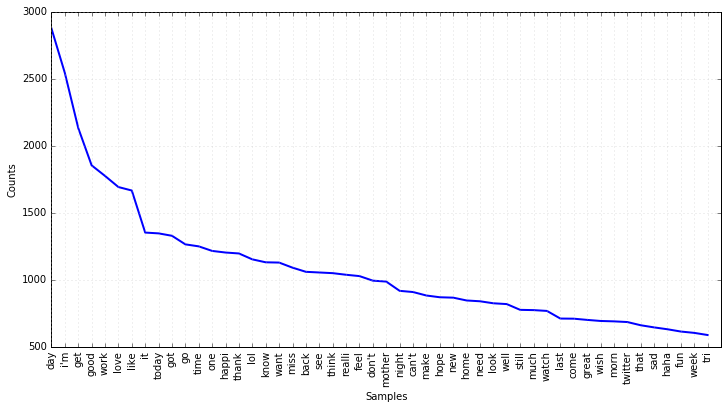

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
fdist.plot(50)

Es posible observar que existen palabras que se repiten más como "day", que muchas otras palabras que tienen una frecuencia mucho menor. Este comportamiento está explicado a través de la Ley de Zipf. 

### d ) Criterio para un problema binario

A continuación se realiza una reducción binaria, con el fin de trabajar con un problema de clasificación de dos clases. Para esto, se agrupan las distintas emociones del dataset como positivas y negativas, +1 y −1 respectivamente. Dicha separación de emociones en las dos clases se realiza según la rueda de emociones de Robert Plutchik, presentada a continuación:

![Plutchik](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Rueda-Plutchik.svg/1200px-Rueda-Plutchik.svg.png "Rueda de emociones")



Se puede ver que cada hoja de la flor está opuesta con otra, siendo una positiva y la otra negativa. Así, se realizó la siguiente clasificación:

* positivas = amor, alivio, divertido, entusiasmo, felicidad
* negativas = enojo, tristeza, odio, preocupación, aburrimiento, sorpresa

Sin embargo quedan dos emociones por clasificar: nautral y vacío. Para determinar en que clase quedarán se verifica la cantidad de datos que ya existe en cada clase, para así balancear los datos de tal forma de no afectar al modelo.


In [87]:
positivas = ['love','relief','fun','enthusiasm','happiness']
negativas = ['anger','sadness','hate','worry','boredom','surprise']

#print emotions_origen

pos = 0
for key in emotions_origen:
    if key in positivas:
        #print emotions[key]
        pos += emotions_origen[key]
print "Cantidad de tweets positivos: " + str(pos)

neg = 0
for key in emotions_origen:
    if key in negativas:
        neg += emotions_origen[key]
print "Cantidad de tweets negativos: " + str(neg)

print "Cantidad neutral:" + str(emotions_origen['neutral'])

print "Cantidad vacio:" + str(emotions_origen['empty'])

Cantidad de tweets positivos: 13112
Cantidad de tweets negativos: 17423
Cantidad neutral:8638
Cantidad vacio:827


Se puede ver que existen muchos mas datos negativos que positivos, que hay muchos mas datos neutrales que vacio y que existe una diferencia de aproximadamente unos 5000 datos. Es por esto que se decide dejar los datos de los tweets neutrales como positivos, para que la diferencia de datos entre las clases no sea de tantos datos y los pocos datos de vacío se añaden a la clase negativa para disminuir un poco el desbalanceo producido.

In [88]:
# Criterio por ahora, neutral positivo,
# empty y surprise negativo, ( Para dejar medianamente balanceado los datos)

positivas = ['love','relief','fun','enthusiasm','happiness','neutral']
negativas = ['anger','sadness','hate','worry','boredom','empty','surprise']

#print emotions_origen

pos = 0
for key in emotions_origen:
    if key in positivas:
        #print emotions[key]
        pos += emotions_origen[key]
print "Cantidad de tweets positivos: " + str(pos)

neg = 0
for key in emotions_origen:
    if key in negativas:
        neg += emotions_origen[key]
print "Cantidad de tweets negativos: " + str(neg)

emotions_l = np.concatenate((negativas,positivas),axis=0)
print emotions_l
#6,-6
emotions = {}
count = -7
for em in range(len(emotions_l)):
    emotions[emotions_l[em]] = str(count+1)
    count += 1
print emotions

Cantidad de tweets positivos: 21750
Cantidad de tweets negativos: 18250
['anger' 'sadness' 'hate' 'worry' 'boredom' 'empty' 'surprise' 'love'
 'relief' 'fun' 'enthusiasm' 'happiness' 'neutral']
{'love': '1', 'neutral': '6', 'fun': '3', 'sadness': '-5', 'boredom': '-2', 'worry': '-3', 'enthusiasm': '4', 'anger': '-6', 'surprise': '0', 'happiness': '5', 'hate': '-4', 'empty': '-1', 'relief': '2'}


In [89]:
def codificar_emotions(arreglo):
    nuevo_arreglo = []
    for i in range(len(arreglo)):
        nuevo_arreglo.append(emotions[arreglo[i]])
    return nuevo_arreglo

#Arreglos decodificados
y_train_em = codificar_emotions(y_train)
y_test_em =  codificar_emotions(y_test)


In [90]:
def codificar(arreglo):
    for i in range(len(arreglo)):
        if arreglo[i] in positivas:
            arreglo[i] = "1"
        else:
            arreglo[i] = "-1"
    return arreglo
y_train = codificar(y_train)
y_test = codificar(y_test)

### e) Representación de documentos

**Para construir un clasificador que determine automáticamente la polaridad de un trozo de texto, será
necesario representar los tweets {ti}n i=1 disponibles como vectores de caracter´ısticas (features). El tipo
de características más utilizado consiste en contar cuántas veces aparecen ciertos términos/palabras en
el texto. Para esto, es necesario un vocabulario que, por lo general, se construye mediante la unión de
todas las palabras que se observen en los tweets.
Se recomienda utilizar las librerías ofrecidas por sklearn de feature extraction in text [12] (CountVectorizer
y TfidfVectorizer ). Recuerde realizar el ajuste (fit) únicamente con el conjunto de entrenamiento,
para luego transformar el conjunto de pruebas (con el método transform).**

A continuación se reprenta cada documento/tweet como una matriz que indica cuántas veces aparecen las palabras en dicho tweet. Para determinar dichas palabras, se construye un vocabulario del corpus, que corresponde a todas las palabras observadas a través de los tweets.

In [91]:
print X_train[:2]

[[u'layin', u'bed', u'headach', u'ughhh', u'waitin', u'call']
 [u'funer', u'ceremoni', u'gloomi', u'friday']]


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Usando TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tweets1 = []
X_tweets2 = []
for i in range(len(X_train)):
    X_tweets1.append((" ").join(X_train[i]))
for i in range(len(X_test)):
    X_tweets2.append((" ").join(X_test[i]))
X_train_tfidf = vectorizer.fit_transform(X_tweets1) # Le damos el vocabulario de entrenamiento!
X_test_tfidf = vectorizer.transform(X_tweets2)

Así, se entregan los datos de entrenamientos separados anteriormente para poder determinar el vocabulario con el que se trabajará. Y luego, se transforma el conjunto de prueba en base al vocabulario generado.

Es importante mencionar que hay que tener un buen diccionario para poder generalizar futuras palabras. Si el diccionario generado es pobre, las predicciones serán pobres. Este problema se enfrenta en todo análisis de texto, siendo el eterno dilema de generar un diccionario suficientemente grande para todas las palabras.

In [93]:
print X_train_tfidf[0]
print "test"
print X_test_tfidf[0]

  (0, 10358)	0.548331771441
  (0, 2158)	0.285620361941
  (0, 8266)	0.345565199898
  (0, 18711)	0.437350991565
  (0, 19342)	0.470072667641
  (0, 3211)	0.293417394178
test
  (0, 16853)	0.268040575605
  (0, 13337)	0.332775286692
  (0, 10606)	0.45381001954
  (0, 10079)	0.216478297174
  (0, 7994)	0.459635466764
  (0, 6986)	0.392640808098
  (0, 5717)	0.368997570226
  (0, 1865)	0.251033260925


In [94]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_tweets1)
X_test_counts = count_vect.transform(X_tweets2)

### f) Entrenar con 5 modelos clasificadores

A continuación se procede a entrenar cinco modelos de clasificación, los cuales finalmente se resumirán en un gráfico comparativo

In [97]:
lista1=[]
lista2=[]
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
clf_bnb = BernoulliNB().fit(X_train_tfidf,y_train)
predicted = clf_bnb.predict(X_test_tfidf)
predicted_train = clf_bnb.predict(X_train_tfidf)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy Bernoulli Naive Bayes train tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy Bernoulli Naive Bayes test tfidf:",(accuracy_score(y_test,predicted))   

print " "
#Multi Naive Bayes == Bernoulli NB
from sklearn.naive_bayes import MultinomialNB
clf_mnb = MultinomialNB().fit(X_train_tfidf,y_train)
predicted = clf_mnb.predict(X_test_tfidf)
predicted_train = clf_mnb.predict(X_train_tfidf)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy Multinomial Naive Bayes train tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy Multinomial Naive Bayes test tfidf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel lineal
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_lineal= SVM()
clf_svm_lineal.set_params(kernel='linear')
clf_svm_lineal.fit(X_train_counts,y_train)
predicted = clf_svm_lineal.predict(X_test_counts)
predicted_train = clf_svm_lineal.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy SVM train kernel lineal:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel lineal:",(accuracy_score(y_test,predicted)) 
print " "
#SVM con kernel rbf
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_rbf= SVM()
clf_svm_rbf.set_params(kernel='rbf')
clf_svm_rbf.fit(X_train_counts,y_train)
predicted = clf_svm_rbf.predict(X_test_counts)
predicted_train = clf_svm_rbf.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy SVM train kernel rbf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel rbf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel plot
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_sig= SVM()
clf_svm_sig.set_params(kernel='poly')
clf_svm_sig.fit(X_train_counts,y_train)
predicted = clf_svm_sig.predict(X_test_counts)
predicted_train = clf_svm_sig.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy SVM train kernel poly 3:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel poly 3:",(accuracy_score(y_test,predicted)) 





Accuracy Bernoulli Naive Bayes train tfidf: 0.800081318613
Accuracy Bernoulli Naive Bayes test tfidf: 0.702753207923
 
Accuracy Multinomial Naive Bayes train tfidf: 0.803615550621
Accuracy Multinomial Naive Bayes test tfidf: 0.692662264856
 
Accuracy SVM train kernel lineal: 0.851843743158
Accuracy SVMs test kernel lineal: 0.693783480752
 
Accuracy SVM train kernel rbf: 0.544647045945
Accuracy SVMs test kernel rbf: 0.540176902953
 
Accuracy SVM train kernel poly 3: 0.544647045945
Accuracy SVMs test kernel poly 3: 0.540176902953


In [98]:
## Regresion Logistica
from sklearn.linear_model import LogisticRegression as LR
clf_lr = LR()
clf_lr.set_params(penalty='l2')
clf_lr.fit(X_train_counts,y_train)
predicted = clf_lr.predict(X_test_counts)
predicted_train = clf_lr.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy train Regresion Logistica :",(accuracy_score(y_train,predicted_train))   
print "Accuracy test Regresion Logistica:",(accuracy_score(y_test,predicted)) 




Accuracy train Regresion Logistica : 0.82200606762
Accuracy test Regresion Logistica: 0.704372741996


In [99]:
## Arbol de Clasificacion 
from sklearn.tree import DecisionTreeClassifier as Tree
clf_tree = Tree() #edit the train_model function
clf_tree.set_params(criterion="entropy",splitter="best")
clf_tree.fit(X_train_counts,y_train)
predicted = clf_tree.predict(X_test_counts)
predicted_train = clf_tree.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy train Arbol :",(accuracy_score(y_train,predicted_train))   
print "Accuracy test Arbol:",(accuracy_score(y_test,predicted)) 

Accuracy train Arbol : 0.989397303975
Accuracy test Arbol: 0.63510651551


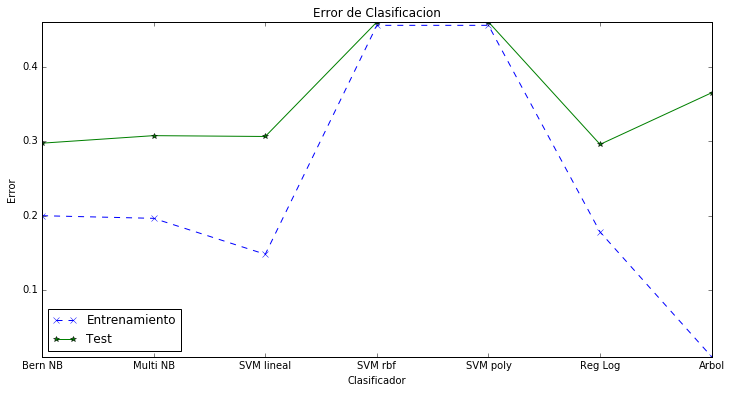

In [100]:
plt.figure(figsize=(12,6))  # Comenzamos un nuevo gráfico (figura)
#lista1 = [1-0.821912238451,1-0.774591061208,1-0.898289181497,1-0.670909830169,1-0.670909830169,1-0.859662840522,1-0.991680480405]
#lista2 =[1-0.737760059798,1-0.71869938956,1-0.740251650679,1-0.677338980939,1-0.677338980939,1-0.750591752834,1-0.698517503426]
plt.title("Error de Clasificacion")
plt.xlabel("Clasificador")
plt.ylabel("Error")
indice = np.arange(7)   # Declara un array
plt.xticks(indice, ("Bern NB", "Multi NB", "SVM lineal", "SVM rbf", "SVM poly", "Reg Log", "Arbol"))   
plt.yticks(np.arange(0.0,1.0,0.1))
plt.plot(lista1, marker='x', linestyle='--', color='b', label = "Entrenamiento")
plt.plot(lista2, marker='*', linestyle='-', color='g', label = "Test")
plt.legend(loc="lower left")
plt.show()

Mediante el gráfico es posible observar que la tendencia a ser bastante diferentes los errores de entrenamiento y test no es seguida por las SVM con kernel RBF (Radial Basis Function) ni Poly, pues la diferencia entre ellos es muy pequeña. Además es importante notar que estás dos SVM dan un mismo error de clasificación, siendo este el más alto, tanto en entrenamiento como en prueba.

Del resto de los clasificadores, Naive Bayes Multinomial tiene un comportamiento bastante bueno, ya que a pesar que el error de entrenamiento no sea muy bajo, su error de test está muy cercano a este, por lo que se podría decir que tiene una buena capacidad de generalización.

Es posible ver que de los error de test, los clasificadoes que tienen un mejor comportamiento son Naive Bayes, SVM lineal y regresión logistica. 

El árbol de clasificación tiene overfitting, ya que su error de entrenamiento, es prácticamente cero, es decir se ajusta muy bien a esos ejemplos, pero su error de test es más alto. A pesar de esto su error de test no es tan alto como tal vez se hubiese esperado. De hecho, está muy acorde a los otros clasificadores

**Obs, Naive Bayes es super rápido para ejecutarse!**

## SOLO CON UN PC RÁPIDO EJECUTAR, TF-IDF
#SVM con kernel lineal
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_lineal_tfidf= SVM()
clf_svm_lineal_tfidf.set_params(kernel='linear')
clf_svm_lineal_tfidf.fit(X_train_tfidf,y_train)
predicted = clf_svm_lineal_tfidf.predict(X_test_tfidf)
predicted_train = clf_svm_lineal_tfidf.predict(X_train_tfidf)
print "Accuracy SVM train kernel lineal tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel lineal tfidf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel rbf
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_rbf_tfidf= SVM()
clf_svm_rbf_tfidf.set_params(kernel='rbf')
clf_svm_rbf_tfidf.fit(X_train_tfidf,y_train)
predicted = clf_svm_rbf_tfidf.predict(X_test_tfidf)
predicted_train = clf_svm_rbf_tfidf.predict(X_train_tfidf)
print "Accuracy SVM train kernel rbf tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel rbf tfidf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel poliniomial tfidf
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_sig_tfidf= SVM()
clf_svm_sig_tfidf.set_params(kernel='poly')
clf_svm_sig_tfidf.fit(X_train_tfidf,y_train)
predicted = clf_svm_sig_tfidf.predict(X_test_tfidf)
predicted_train = clf_svm_sig_tfidf.predict(X_train_tfidf)
print "Accuracy SVM train kernel poly 3 tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel poly 3 tfidf:",(accuracy_score(y_test,predicted))

LDA y QDA explotan con la dimensionalidad por eso no lo ocuparemos

## NO EJECUTAR! PROBLEMAS DE MEMORIA!


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()

print X_train_counts[0]

model.fit(X_train_counts.toarray(),y_train) # Memory Error .toarray
predicted = model.predict(X_test_counts)


### g) Classification Report

**Utilice y explique las métricas que calcula la función classification report de la librería sklearn. En base
a las distintas métricas calculadas ¿Cuáles clasificadores son los que mejor se comportan?**

Se procedió a crear la función de evaluación de desempeño para los clasificadores. Las métricas que utiliza la función classification_report de la librería sklearn son tres:
* Precision: Capacidad del clasificador de no etiquetar como positiva una muestra que es negativa, y viceversa. 
* Recall: Capacidad del clasificador para encontrar todas las muestras positivas/relevantes.
* F1-Score: Puede interpretarse como una media armónica ponderada de precision y recall.
* Support: Cantidad de ocurrencias de cada clase.

In [101]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy: %f"%(acc_tr)
    print "Test Accuracy: %f"%(acc_test)
    print "Detailed Analysis Testing Results ..."
    print (classification_report(yt,model.predict(xt)))

In [102]:
print "tf-idf: \n \n"
print "Bernoulli Naive Bayes \n"
score_the_model(clf_bnb,X_train_tfidf,y_train,X_test_tfidf,y_test)
print "Multinomial Naive Bayes \n"
score_the_model(clf_mnb,X_train_tfidf,y_train,X_test_tfidf,y_test)
print "Multinomial SVM kernel lineal \n"
score_the_model(clf_svm_lineal,X_train_counts,y_train,X_test_counts,y_test)
print "Multinomial SVM kernel RBF \n"
score_the_model(clf_svm_rbf,X_train_counts,y_train,X_test_counts,y_test)
print "Multinomial SVM kernel sigmoidal \n"
score_the_model(clf_svm_sig,X_train_counts,y_train,X_test_counts,y_test)
print "Logistic Regression \n"
score_the_model(clf_lr,X_train_counts,y_train,X_test_counts,y_test)
print "Clasification tree \n"
score_the_model(clf_tree,X_train_counts,y_train,X_test_counts,y_test)

tf-idf: 
 

Bernoulli Naive Bayes 

Training Accuracy: 0.800081
Test Accuracy: 0.702841
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.70      0.62      0.66      3691
          1       0.70      0.78      0.74      4336

avg / total       0.70      0.70      0.70      8027

Multinomial Naive Bayes 

Training Accuracy: 0.803616
Test Accuracy: 0.692624
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.70      0.57      0.63      3691
          1       0.69      0.79      0.74      4336

avg / total       0.69      0.69      0.69      8027

Multinomial SVM kernel lineal 

Training Accuracy: 0.851844
Test Accuracy: 0.693745
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.69      0.60      0.64      3691
          1       0.69      0.77      0.73      4336

avg / total       0.69      0.69      0.69   

En base a las métricas anteriormente explicadas y comparando resultados entre los clasificadores, es posible obsevar que se tienen buenos resultados con Regresión Logística y Naive Bayes Bernoulli, con respecto a las métricas presentadas. Tal vez, se hubiese pensado Naive Bayes Bernoulli era la mejor opción a priori, ya que es el clasificador comúnmente usado para clasificación de texto.

Luego Naive Bayes Bernoulli Multinomial y SVM lineal son las que mejor se comportan. Y finalmente, las SVM no lineal, sigmoidal y RBF, son las que peor se comportan, y tal como se vió anteriormente, se comportan igual.



###  h) [Opcional]

In [111]:
import random
print clf_lr
test_pred = clf_lr.predict_proba(X_test_counts)
spl = random.sample(xrange(len(test_pred)), 15)
for text, sentiment in zip(df_test.content[spl], test_pred[spl]):
    print sentiment, text

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[ 0.25562219  0.74437781] Back home  Had a great time!
[ 0.89480453  0.10519547] nan
[ 0.75412049  0.24587951] nan
[ 0.01339253  0.98660747] nan
[ 0.58773909  0.41226091] now i'm awake i can't get back to sleep
[ 0.51830179  0.48169821] @lavsmohan In my case, it's going to be exams showing me a thing or two.  I'm very much hopeful about November '09, though.
[ 0.13641754  0.86358246] nan
[ 0.60395332  0.39604668] nan
[ 0.31025185  0.68974815] nan
[ 0.03163611  0.96836389] nan
[ 0.27033113  0.72966887] @chellemariee I have my 830 class  fuckin school! what time you work wed? if jade comes ima have to get her in antioch at amtrak.
[ 0.34559806  0.65440194] nan
[ 0.5795255  0.4204745] what do u do when ur dads losing it mentaly 

### i) Multilabel

Ahora, el problema de clasificación será extendido a múltiples clases. Así, la tarea del nuevo clasificador será predecir una de las distintas emociones de cada tweet. Para esto cada clase fue asignada a un valor, el cual ya fue codificado con anterioridad.

In [117]:
lista1=[]
lista2=[]
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
clf_bnb = BernoulliNB().fit(X_train_tfidf,y_train_em)
predicted = clf_bnb.predict(X_test_tfidf)
predicted_train = clf_bnb.predict(X_train_tfidf)
lista1.append(1-accuracy_score(y_train_em,predicted_train))
lista2.append(1-accuracy_score(y_test_em,predicted))
print "Accuracy Bernoulli Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy Bernoulli Naive Bayes test:",(accuracy_score(y_test_em,predicted))   

print " "
#Multi Naive Bayes == Bernoulli NB
from sklearn.naive_bayes import MultinomialNB
clf_mnb = MultinomialNB().fit(X_train_tfidf,y_train_em)
predicted = clf_mnb.predict(X_test_tfidf)
predicted_train = clf_mnb.predict(X_train_tfidf)
lista1.append(1-accuracy_score(y_train_em,predicted_train))
lista2.append(1-accuracy_score(y_test_em,predicted))
print "Accuracy Multinomial Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy Multinomial Naive Bayes test:",(accuracy_score(y_test_em,predicted))
print " "

from sklearn.svm import SVC as SVM #SVC is for classification
model= SVM()
model.set_params(kernel='linear')
model.fit(X_train_counts,y_train_em)

predicted = model.predict(X_test_counts)
predicted_train = model.predict(X_train_counts)

lista1.append(1-accuracy_score(y_train_em,predicted_train))
lista2.append(1-accuracy_score(y_test_em,predicted))
print "Accuracy SVM train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy SVMs test:",(accuracy_score(y_test_em,predicted)) 

print " "
## Regresion Logistica
from sklearn.linear_model import LogisticRegression as LR
clf_lr = LR()
clf_lr.set_params(penalty='l2')
clf_lr.fit(X_train_counts,y_train_em)
predicted = clf_lr.predict(X_test_counts)
predicted_train = clf_lr.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train_em,predicted_train))
lista2.append(1-accuracy_score(y_test_em,predicted))
print "Accuracy train Regresion Logistica :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica:",(accuracy_score(y_test_em,predicted)) 
print " "
## Arbol de Clasificacion 
from sklearn.tree import DecisionTreeClassifier as Tree
clf_tree = Tree() #edit the train_model function
clf_tree.set_params(criterion="entropy",splitter="best")
clf_tree.fit(X_train_counts,y_train_em)
predicted = clf_tree.predict(X_test_counts)
predicted_train = clf_tree.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train_em,predicted_train))
lista2.append(1-accuracy_score(y_test_em,predicted))
print "Accuracy train Arbol :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Arbol:",(accuracy_score(y_test_em,predicted)) 
print " "


Accuracy Bernoulli Naive Bayes train: 0.456041034623
Accuracy Bernoulli Naive Bayes test: 0.320044848636
 
Accuracy Multinomial Naive Bayes train: 0.4344603259
Accuracy Multinomial Naive Bayes test: 0.307960632864
 
Accuracy SVM train: 0.740781284209
Accuracy SVMs test: 0.335368132553
 
Accuracy train Regresion Logistica : 0.629343508585
Accuracy test Regresion Logistica: 0.352061791454
 
Accuracy train Arbol : 0.975854627342
Accuracy test Arbol: 0.265479008347
 


In [118]:
print lista1

[0.54395896537703692, 0.56553967410002182, 0.25921871579144906, 0.37065649141463108, 0.024145372658180286]


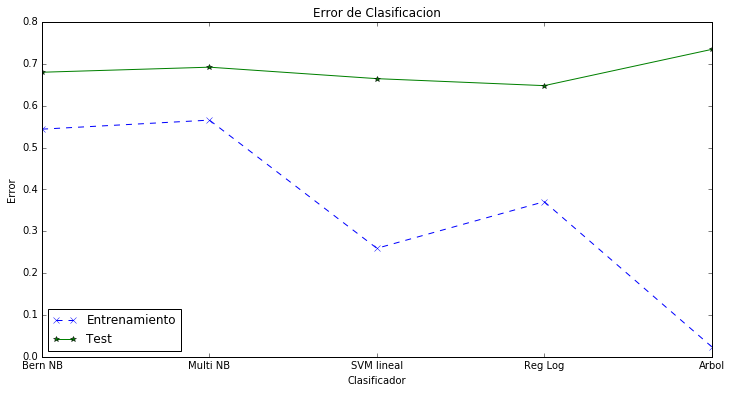

In [119]:
plt.figure(figsize=(12,6))  # Comenzamos un nuevo gráfico (figura)
#lista1 = [1-0.459731648578,1-0.450911706753,1-0.788978200357,1-0.672411096863,1-0.977324617646]
#lista2 =[1-0.312320916905,1-0.30783605332,1-0.333873178024,1-0.350317677837,1-0.267472281051]
plt.title("Error de Clasificacion")
plt.xlabel("Clasificador")
plt.ylabel("Error")
indice = np.arange(5)   # Declara un array
plt.xticks(indice, ("Bern NB", "Multi NB", "SVM lineal", "Reg Log", "Arbol"))   
#plt.yticks(np.arange(0.0,1.0,0.1))
plt.plot(lista1, marker='x', linestyle='--', color='b', label = "Entrenamiento")
plt.plot(lista2, marker='*', linestyle='-', color='g', label = "Test")
plt.legend(loc="lower left")
plt.show()

Para este nuevo caso de estudio es posiblever que los resultados empeoraron bastante. De hecho si se observa el eje Y del gráfico se puede ver que ahora tiene un rango más amplio, llegando hasta el 0.8 en vez del 0.4.

Para estos casos ve una tendencia al overfitting sobre los clasificadores, pues se tine un bajo error de entrenamiento, es decir la clasificasión se ajusta bien a los ejemplos entregados, pero a la hora de probar con nuevos ejemplos, estos clasificadores se comportan bastante mal rodeando un error de 0.7. Al igual que en el caso de dos clases se puede ver que el clasificador que sufre mayor overfitting es el árbol de clasificación. 

Este mal comportamiento general, es obtenido por la poca cantidad de ejemplos para entrenamiento que se tienen por clase, teniendo algunas con un orden de los cientos de ejemplos y otros de los cientos.

### j) Clasificadores extendidos por defecto

A continuación se utilizan claficadores que son extendidos por defecto para múltiples clases, como regresión lógistica, árbol de decisión y naive bayes. Estos clasificadores serán utilizads para detectar las emociones en cada tweet.

In [120]:
lista1=[]
lista2=[]
#Regresión Logistica
from sklearn.linear_model import LogisticRegression
clf_lr_def = LogisticRegression()
clf_lr_def.set_params(multi_class='multinomial', solver='newton-cg')
clf_lr_def.fit(X_train_counts,y_train_em)
predicted = clf_lr_def.predict(X_test_counts)
predicted_train = clf_lr_def.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy train Regresion Logistica :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica:",(accuracy_score(y_test_em,predicted)) 
print " "



from sklearn.tree import DecisionTreeClassifier as DTC
clf_dtc_def = DTC()
clf_dtc_def.fit(X_train_counts,y_train_em)
predicted = clf_dtc_def.predict(X_test_counts)
predicted_train = clf_dtc_def.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy train Árbol de decisión :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Árbol de decisión :",(accuracy_score(y_test_em,predicted)) 
print " "

from sklearn.naive_bayes import BernoulliNB
clf_bnb_def = BernoulliNB()
clf_bnb_def.fit(X_train_counts,y_train_em)
predicted = clf_bnb_def.predict(X_test_counts)
predicted_train = clf_bnb_def.predict(X_train_counts)
lista1.append(1-accuracy_score(y_train,predicted_train))
lista2.append(1-accuracy_score(y_test,predicted))
print "Accuracy train NB Bernoulli :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test NB Bernoulli:",(accuracy_score(y_test_em,predicted)) 

Accuracy train Regresion Logistica : 0.658461827167
Accuracy test Regresion Logistica: 0.347950666501
 
Accuracy train Árbol de decisión : 0.975854627342
Accuracy test Árbol de decisión : 0.265852746979
 
Accuracy train NB Bernoulli : 0.456041034623
Accuracy test NB Bernoulli: 0.320044848636


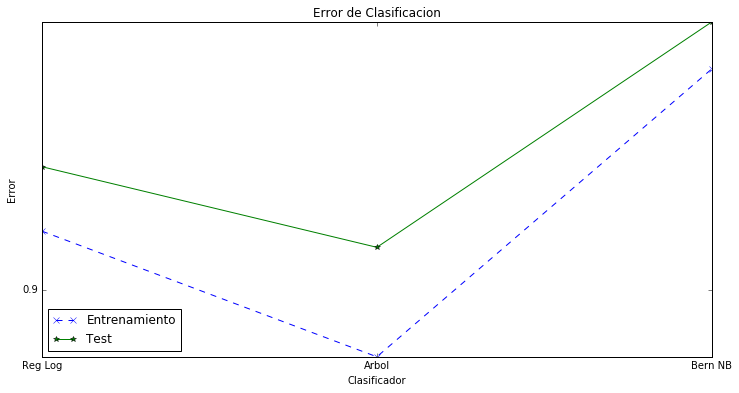

In [124]:
plt.figure(figsize=(12,6))  # Comenzamos un nuevo gráfico (figura)
#lista1 = [1-0.704531948832,1-0.977324617646,1-0.459731648578]
#lista2 =[1-0.343714962003,1-0.267223121963,1-0.312320916905]
plt.title("Error de Clasificacion")
plt.xlabel("Clasificador")
plt.ylabel("Error")
indice = np.arange(5)   # Declara un array
plt.xticks(indice, ("Reg Log", "Arbol","Bern NB" ))   
plt.yticks(np.arange(0.0,1.0,0.1))
plt.plot(lista1, marker='x', linestyle='--', color='b', label = "Entrenamiento")
plt.plot(lista2, marker='*', linestyle='-', color='g', label = "Test")
plt.legend(loc="lower left")
plt.show()

Es posible observar que para este caso se mantiene la tendencia de malos clasificadores, dado que tienen un alto error de prueba. Al igual que se mencionó anteriormente, esto es debido a la poca cantidad de datos por clase que permitan realizar una buena generalización.

En este caso también ocurre que el árbol de clasificación es el que peor se comporta, teniendo bastante overfitting. Como se ve en la gráfica, el error de entrenamiento es bastante pequeño, casi nula, pero a la hora se clasificar nuevos datos, su rendimiento es deficiente con un error de más del 0.7


### k) Clasificadores binarios extendidos mediante One vs One y One vs All

Luego, se utilizan clasificadores binarios que pueden ser extendidos a través de otras técnicas, tal como One vs
One y One vs All/Rest.

Las máquinas One vs All y One vs One son dos formas distintas de clasificadores binarios extendidos a multiclases. En el primer se entrena un clasificador por clase, se le entregan input de ejemplos pertenecientes a una clase y todos los otros ejemplos se toman como no pertenecientes a la clase. Por otro lado, el clasificador One vs one entrena $\frac{K(K-1)}{2}$ clasificadores y a cada uno de ellos se le entregan input de ejemplos de pertenencia a dos clases distintas, así puede diferenciar entre dos clases en especifico y el aprendizaje entre todos los clasificadores podrán determinar la pertenencia de un elemtno a una se las múltiples clases.

In [125]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
# Extension de Bernoulli Naive
clf_multibnb_1va = OneVsRestClassifier(clf_bnb)
clf_multibnb_1va.fit(X_train_tfidf,y_train_em)
predicted = clf_multibnb_1va.predict(X_test_tfidf)
predicted_train = clf_multibnb_1va.predict(X_train_tfidf)
print "Accuracy One vs All Bernoulli Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs All Bernoulli Naive Bayes test:",(accuracy_score(y_test_em,predicted))  
print " "
clf_multibnb_1v1 = OneVsOneClassifier(clf_bnb)
clf_multibnb_1v1.fit(X_train_tfidf,y_train_em)
predicted = clf_multibnb_1v1.predict(X_test_tfidf)
predicted_train = clf_multibnb_1v1.predict(X_train_tfidf)
print "Accuracy One vs One Bernoulli Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs One Bernoulli Naive Bayes test:",(accuracy_score(y_test_em,predicted))  

Accuracy One vs All Bernoulli Naive Bayes train: 0.488662308823
Accuracy One vs All Bernoulli Naive Bayes test: 0.327768780366
 
Accuracy One vs One Bernoulli Naive Bayes train: 0.456041034623
Accuracy One vs One Bernoulli Naive Bayes test: 0.320044848636


In [126]:
#Extension de SVM Lineal
clf_svm_1va = OneVsRestClassifier(model)
clf_svm_1va.fit(X_train_counts,y_train_em)
predicted = clf_svm_1va.predict(X_test_counts)
predicted_train = clf_svm_1va.predict(X_train_counts)
print "Accuracy One vs All SVM lineal train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs All SVM lineal test:",(accuracy_score(y_test_em,predicted))  

clf_svm_1v1 = OneVsOneClassifier(model)
clf_svm_1v1.fit(X_train_counts,y_train_em)
predicted = clf_svm_1v1.predict(X_test_counts)
predicted_train = clf_svm_1v1.predict(X_train_counts)
print "Accuracy One vs One SVM lineal train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs One SVM lineal test:",(accuracy_score(y_test_em,predicted)) 

Accuracy One vs All SVM lineal train: 0.744659556501
Accuracy One vs All SVM lineal test: 0.309455587393
Accuracy One vs One SVM lineal train: 0.734901322991
Accuracy One vs One SVM lineal test: 0.340102155226


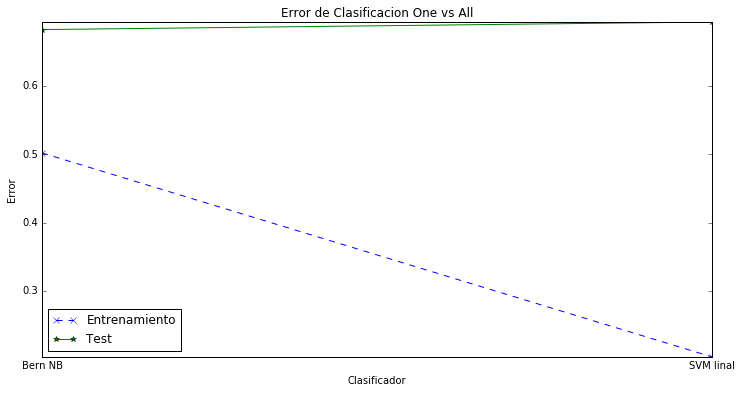

In [127]:
plt.figure(figsize=(12,6))  # Comenzamos un nuevo gráfico (figura)
lista1 = [1-0.497795014544,1-0.795765176868]
lista2 =[1-0.317428678211,1-0.306341098792]
plt.title("Error de Clasificacion One vs All")
plt.xlabel("Clasificador")
plt.ylabel("Error")
indice = np.arange(3)   # Declara un array
plt.xticks(indice, ("Bern NB", "SVM linal" ))   
plt.yticks(np.arange(0.0,1.0,0.1))
plt.plot(lista1, marker='x', linestyle='--', color='b', label = "Entrenamiento")
plt.plot(lista2, marker='*', linestyle='-', color='g', label = "Test")
plt.legend(loc="lower left")
plt.show()

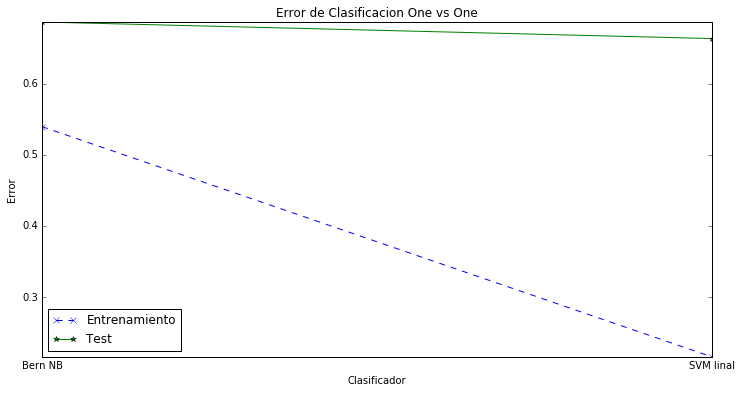

In [128]:
plt.figure(figsize=(12,6))  # Comenzamos un nuevo gráfico (figura)
lista1 = [1-0.459731648578,1- 0.783786319707]
lista2 =[1-0.312320916905,1-0.335617291641]
plt.title("Error de Clasificacion One vs One")
plt.xlabel("Clasificador")
plt.ylabel("Error")
indice = np.arange(3)   # Declara un array
plt.xticks(indice, ("Bern NB", "SVM linal" ))   
plt.yticks(np.arange(0.0,1.0,0.1))
plt.plot(lista1, marker='x', linestyle='--', color='b', label = "Entrenamiento")
plt.plot(lista2, marker='*', linestyle='-', color='g', label = "Test")
plt.legend(loc="lower left")
plt.show()

###  l) Regresión Logística extendido One vs Rest y Multinomial

In [129]:
clf_lr_ovr = LR(multi_class="ovr")
clf_lr_mn  = LR(multi_class="multinomial",solver="newton-cg")

clf_lr_ovr.fit(X_train_counts,y_train_em)
clf_lr_mn.fit(X_train_counts,y_train_em)


predicted = clf_lr_ovr.predict(X_test_counts)
predicted_train = clf_lr_ovr.predict(X_train_counts)
print "Accuracy train Regresion Logistica OVR :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica OVR:",(accuracy_score(y_test_em,predicted)) 
print " "
predicted = clf_lr_mn.predict(X_test_counts)
predicted_train = clf_lr_mn.predict(X_train_counts)
print "Accuracy train Regresion Logistica Multinomial :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica Multinomial:",(accuracy_score(y_test_em,predicted)) 

Accuracy train Regresion Logistica OVR : 0.629343508585
Accuracy test Regresion Logistica OVR: 0.352061791454
 
Accuracy train Regresion Logistica Multinomial : 0.658461827167
Accuracy test Regresion Logistica Multinomial: 0.347950666501


### m) Comparacion entre clasificadores

Se puede ver que los mejores clasificadores obtenidos son Naive Bayes Bernoulli y Regresión logística, para el caso binario, y eso se mantiene Naive Bayes para el caso multiclase.

Casi todos los clasificadores tienen un alto accuracy para los datos de entrenamiento y bajo para los datos de prueba, por lo cual se pude decir que subren de overfitting, excepto los clasificadores de Naive Bayes que tienen bajo accuracy en ambos casos. Igualmente este resultado no es una buena generalización, o sea no es un buen clasificador,

A través de los resultados mostrados en este estudio, es posible observar que los clasificadores funcionan mucho mejor cuando solo tienen que decidir entre dos clases. Este comportamiento se debe a que para el caso binario hay aproximadamente 20.000 datos para entrenar cada clase, mientras que para el caso en que el clasificador debe decidir entre varias clases, existen poco datos para entrenar cada una de estas clses. Así, con pocos datos de entrenamientos no se puede alcanzar una capacidad de generalización para nuevos datos.